In [31]:
import json
import os

from analysis import *
from plot_main import *

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'


### Load model and run simulation on experimental reward schedule and stimuli

In [32]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/dual_hierarchical_good_based_large_regularization/'
os.chdir('/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN')
# os.chdir('/Volumes/f005d7d/attn-rnn/Attn-WM-RNN')
# exp_dir = 'exp/dual_hierarchical_good_based_2_area_no_choice_to_area_1'

f = open(os.path.join(exp_dir, 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
ITI = 0.25
choice_start = 0.6
rwd_start = 0.75
stim_end = 0.9
mask_onset = 0.4
# experiment timeline [0.75 fixation, 2.5 stimulus, 0.5 action presentation, 1.0 reward presentation]
# 2021 paper          [0.5          , 0.7         , 0.3                    , 0.2                   ]
# here                [0.2          , 0.6         , 0.15                   , 0.15                  ]

exp_times = {
    'start_time': -ITI,
    'end_time': stim_end,
    'stim_onset': 0.0,
    'stim_end': stim_end,
    'mask_onset': mask_onset,
    'mask_end': choice_start,
    'choice_onset': choice_start,
    'choice_end': stim_end,
    'rwd_onset': rwd_start,
    'rwd_end': stim_end,
    'total_time': ITI+stim_end,
    'dt': args['dt']}
log_interval = 1
task_mdprl = MDPRL(exp_times, args['input_type'])
print('loaded task')

loaded args
loaded task


In [33]:
input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]

args['num_options'] = 2 if 'double' in args['task_type'] else 1

num_options = 1 if args['task_type']=='value' else 2
if args['decision_space']=='action':
    output_size = num_options
elif args['decision_space']=='good':
    output_size = args['stim_val']**args['stim_dim']
else:
    raise ValueError('Invalid decision space')
args['output_size'] = output_size


model_specs = {'input_size': input_size, 'hidden_size': args['hidden_size'], 'output_size': output_size, 'num_options': num_options,
                'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt': args['dt'], 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'rwd_input': args.get('rwd_input', False), 'action_input': args['action_input'], 
                'sep_lr': args['sep_lr'], 'num_choices': 2 if 'double' in args['task_type'] else 1,
                'structured_conn': args['structured_conn'], 'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (0.5, 0.5), 'input_plastic': not args['input_plas_off']}

E_SIZE = round(args['hidden_size']*args['e_prop'])
I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
NUM_AREAS = args['num_areas']

model = HierarchicalRNN(**model_specs)
print(model)
for n, p in model.named_parameters():
    print(n, p.numel())

state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth.tar'), map_location=torch.device('cpu'))['model_state_dict']
print(model.load_state_dict(state_dict))

HierarchicalRNN(
  (rnn): PlasticLeakyRNNCell(
    (x2h): EILinear()
    (aux2h): EILinear()
    (h2h): EILinear()
  )
  (h2o): EILinear()
)
rnn.kappa_rec 25600
rnn.x2h.weight 10080
rnn.aux2h.weight 4640
rnn.h2h.weight 25600
rnn.h2h.bias 160
h2o.weight 1728
<All keys matched successfully>


In [34]:
def run_model(args, model, task_mdprl, n_samples=None):
    model.eval()
    all_saved_states = defaultdict(list)
    output_size = args['output_size']

#     all_dim_orders = list(itertools.permutations(range(1, 4)))
#     all_dim_orders = [list(dim_order) for dim_order in all_dim_orders]

    if n_samples is None:
        n_samples = task_mdprl.test_stim_order.shape[1]
    with torch.no_grad():
        for batch_idx in tqdm.tqdm(range(n_samples)):
            # sample random order to permute reward schedule dimensions
#             curr_dim_order = all_dim_orders[np.random.choice(len(all_dim_orders))]
            pop_s, target_valid, output_mask, rwd_mask, ch_mask, index_s, prob_s = task_mdprl.generateinputfromexp(
                batch_size=1, test_N_s=args['test_N_s'], num_choices=args['num_options'], participant_num=batch_idx)
            
#             all_saved_states['dim_orders'].append(torch.from_numpy(np.expand_dims(np.array(curr_dim_order), axis=(0,1,2)))) # num trials (1) X time_steps(1) X batch_size(1) X num_dims
            # add empty list for the current episode
            all_saved_states['whs_final'].append([])

            all_saved_states['stimuli'].append(torch.from_numpy(np.expand_dims(index_s, axis=(1,2)))) # num trials X time_steps(1) X batch_size(1) X num_choices
            all_saved_states['reward_probs'].append(torch.from_numpy(np.expand_dims(prob_s, axis=(1,)))) # num_trials X time_steps(1) X batch_size X num_choices

            all_saved_states['choices'].append([])
            all_saved_states['rewards'].append([])
            all_saved_states['choose_better'].append([])
            
            all_saved_states['hs_pre'].append([])
            all_saved_states['hs_post'].append([])

            # reinitialize hidden layer activity
            hidden = None

            for i in range(len(pop_s['pre_choice'])):
                # first phase, give stimuli and no feedback
                output, hs, hidden, ss = model(pop_s['pre_choice'][i], hidden=hidden, 
                                                DAs=torch.zeros(1, args['batch_size'], 1)*rwd_mask['pre_choice'],
                                                Rs=torch.zeros(1, args['batch_size'], 2)*rwd_mask['pre_choice'],
                                                acts=torch.zeros(1, args['batch_size'], output_size)*ch_mask['pre_choice'],
                                                save_weights=True)

                # save activities before reward
                all_saved_states['hs_pre'][-1].append(hs) # [num_sessions, [num_trials, [time_pre, num_batch_size, hidden_size]]]

                if args['task_type']=='on_policy_double':
                    # use output to calculate action, reward, and record loss function
                    if args['decision_space']=='action':
                        action = torch.argmax(output[-1,:,:], -1) # batch size
                        rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action]).float()
                        all_saved_states['choose_better'][-1].append((action==torch.argmax(prob_s[i], -1)).float().squeeze())
                    elif args['decision_space']=='good':
#                         action_valid = torch.argmax(output[-1,:,index_s[i]], -1) # the object that can be chosen (0~1), (batch size, )
                        action_valid = torch.multinomial(output[-1,:,index_s[i]].softmax(-1), num_samples=1).squeeze(-1)
                        action = index_s[i, action_valid] # (batch size, )
                        rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action_valid]).long()
                        all_saved_states['choose_better'][-1].append((action_valid==torch.argmax(prob_s[i], -1)).float()[None,...]) 
                    all_saved_states['rewards'][-1].append(rwd.float()[None,...])
                    all_saved_states['choices'][-1].append(action[None,...])
                elif args['task_type'] == 'value':
                    raise NotImplementedError
                    rwd = (torch.rand(1)<prob_s[i]).float()
                    output = output.reshape(output_mask['target'].shape[0], 1, output_size)
                    acc.append(((output-target_valid['pre_choice'][i])*output_mask['target'].float().unsqueeze(-1)).pow(2).mean(0)/output_mask['target'].float().mean())
                    curr_rwd.append(rwd)
                
                if args['task_type']=='on_policy_double':
                    # use the action (optional) and reward as feedback
                    pop_post = pop_s['post_choice'][i]
                    action_enc = torch.eye(output_size)[action]
                    rwd_enc = torch.eye(2)[rwd]
                    action_enc = action_enc*ch_mask['post_choice']
                    rwd_enc = rwd_enc*rwd_mask['post_choice']
                    DAs = (2*rwd.float()-1)*rwd_mask['post_choice']
                    _, hs, hidden, ss = model(pop_post, hidden=hidden, Rs=rwd_enc, acts=action_enc, DAs=DAs, save_weights=False)
                elif args['task_type'] == 'value':
                    raise NotImplementedError
                    pop_post = pop_s['post_choice'][i]
                    rwd_enc = torch.eye(2)[rwd]
                    DAs = (2*rwd.float()-1)*rwd_mask['post_choice']
                    _, hs, hidden, ss = model(pop_post, hidden=hidden, Rs=rwd_enc, acts=None, DAs=DAs, save_weights=False)
                
                all_saved_states['hs_post'][-1].append(hs) # [num_sessions, [num_trials, [time_post, num_batch_size, hidden_size]]]
                all_saved_states['whs_final'][-1].append(hidden[3][None,...]) 
                    # [num_sessions, [num_trials, [1, num_batch_size, hidden_size, hidden_size]]]

            # stack to create a trial dimension for each session
            for k in all_saved_states.keys():
                if isinstance(all_saved_states[k][-1], list):
                    all_saved_states[k][-1] = torch.stack(all_saved_states[k][-1], axis=0)
            # [num_sessions, [num_trials, time_steps, num_batch_size, ...]]

        # concatenate all saved states along the batch dimension
        for k in all_saved_states.keys():
            all_saved_states[k] = torch.cat(all_saved_states[k], axis=2) # [num_trials, time_steps, num_sessions, ...]
            
        # all saved states of the form [num_trials, time_steps, num_sessions, ...]

        # concatenate activities pre- and post-feedback
        all_saved_states['hs'] = torch.cat([all_saved_states['hs_pre'], all_saved_states['hs_post']], dim=1)

        # concatenate all accuracies and rewards
        print(all_saved_states['rewards'].mean(), all_saved_states['choose_better'].mean())
        
        for k, v in all_saved_states.items():
            print(k, v.shape)
        
        return all_saved_states


In [35]:
# run model

import pickle

test_activities_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn/test_activities'

if os.path.exists(test_activities_dir):
    print('found previous record pickle, loading previous results')
    with open(test_activities_dir, 'rb') as f:
        all_saved_states = pickle.load(f)
    print('loaded previous results')
else:
    all_saved_states = run_model(args, model, task_mdprl)
    print('simulation complete')
    with open(test_activities_dir, 'wb') as f:
        pickle.dump(all_saved_states, f)
    print(f'saved results to {test_activities_dir}')

100%|██████████| 92/92 [27:20<00:00, 17.83s/it]


tensor(0.5808) tensor(0.6800)
whs_final torch.Size([432, 1, 92, 160, 160])
stimuli torch.Size([432, 1, 92, 2])
reward_probs torch.Size([432, 1, 92, 2])
choices torch.Size([432, 1, 92])
rewards torch.Size([432, 1, 92])
choose_better torch.Size([432, 1, 92])
hs_pre torch.Size([432, 43, 92, 160])
hs_post torch.Size([432, 15, 92, 160])
hs torch.Size([432, 58, 92, 160])
simulation complete
saved results to /dartfs-hpc/scratch/f005d7d/attn-rnn/test_activities


### Learning Curve

In [36]:
def plot_mean_and_std(ax, m, sd, label, color, alpha=1):
    if label is not None:
        ax.plot(m, alpha=alpha, label=label, c=color)
    else:
        ax.plot(m, alpha=alpha, c=color)
    ax.fill_between(range(len(m)), m-sd, m+sd, color=color, alpha=0.1)

def plot_learning_curve(args, all_rewards, all_choose_betters):
    # fig_all = plt.figure('perf_all')
    # ax = fig_all.add_subplot()
    # ax.imshow(all_l[0].squeeze(-1).t(), interpolation='nearest')
    # ax.set_xlabel('Trials')
    # ax.set_ylabel('Episodes')
    # plt.tight_layout()
    # # plt.savefig(f'plots/{plot_args.exp_dir}/performance_all')
    # plt.show()
    
    window_size = 20
    all_choose_betters = convolve2d(all_choose_betters.squeeze(), np.ones((window_size, 1))/window_size, mode='valid')
    all_rewards = convolve2d(all_rewards.squeeze(), np.ones((window_size, 1))/window_size, mode='valid')

    fig_summ = plt.figure('perf_summary')
    ax = fig_summ.add_subplot()
    plot_mean_and_std(ax, 
                      all_choose_betters.mean(axis=1), 
                      all_choose_betters.std(axis=1)/np.sqrt(all_choose_betters.squeeze().shape[1]), 
                      label='Percent Better', color='black')
    plot_mean_and_std(ax, 
                      all_rewards.mean(axis=1), 
                      all_rewards.std(axis=1)/np.sqrt(all_rewards.squeeze().shape[1]), 
                      label='Reward', color='grey')
    ax.vlines(x=args['N_s_min'], ymin=0.3, ymax=0.9, colors='black', linestyle='--')
    ax.legend()
    ax.set_xlabel('Trials')
    ax.set_ylabel('Percent Correct')
    plt.tight_layout()
    plt.savefig(f'plots/{args["exp_dir"]}/learning_curve.pdf')
#     plt.show()

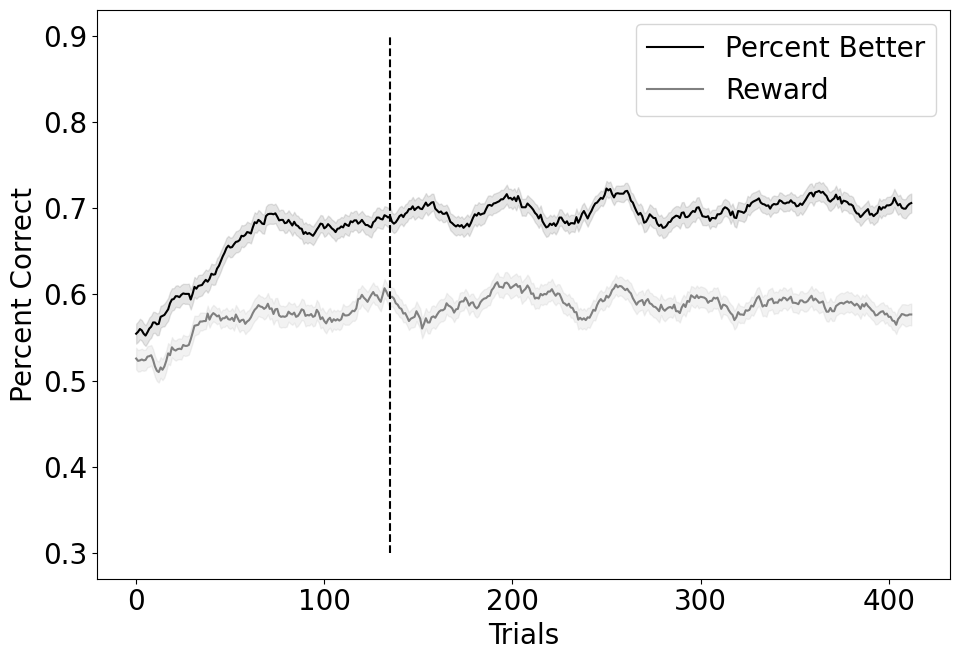

In [37]:
plot_learning_curve(args, all_saved_states['rewards'], all_saved_states['choose_better'])

In [38]:
def plot_weight_summary(args, ws):
    trials, timesteps, batch_size, post_dim, pre_dim = ws.shape
    assert(timesteps==1)
    ws = ws.squeeze()
    
    # norm of update
    fig = plt.figure()
    ax = fig.add_subplot()
    diff_ws = ((ws[1:]-ws[:-1])**2).sum([-1, -2])
    plot_mean_and_std(ax, diff_ws.mean(1), diff_ws.std(1)/np.sqrt(batch_size), None, color='black')
    ax.set_xlabel('Trial')
    ax.set_ylabel(r'$|\Delta W|_2$')
    fig.show()
    print('Finished calculating norm of update')

    # norm of weights
    fig = plt.figure()
    ax = fig.add_subplot()
    norm_ws = (ws**2).sum([-1, -2]) # frobenius norm
    plot_mean_and_std(ax, norm_ws.mean(1), norm_ws.std(1)/np.sqrt(batch_size), None, color='black')
    ax.set_xlabel('Trial')
    ax.set_ylabel(r'$|W|_2$')
    fig.show()
    print('Finished calculating weight norms')

    # variance of entries across trials
    fig = plt.figure()
    ax = fig.add_subplot()
    mean_ws = ws.mean(1, keepdims=True)
    std_ws = ((ws-mean_ws)**2).sum([-1, -2])
    plot_mean_and_std(ax, std_ws.mean(1), std_ws.std(1)/np.sqrt(batch_size), None, color='black')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Cross session variability')
    fig.show()
    print('Finished calculating variability')

Finished calculating norm of update
Finished calculating weight norms


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found

Finished calculating variability


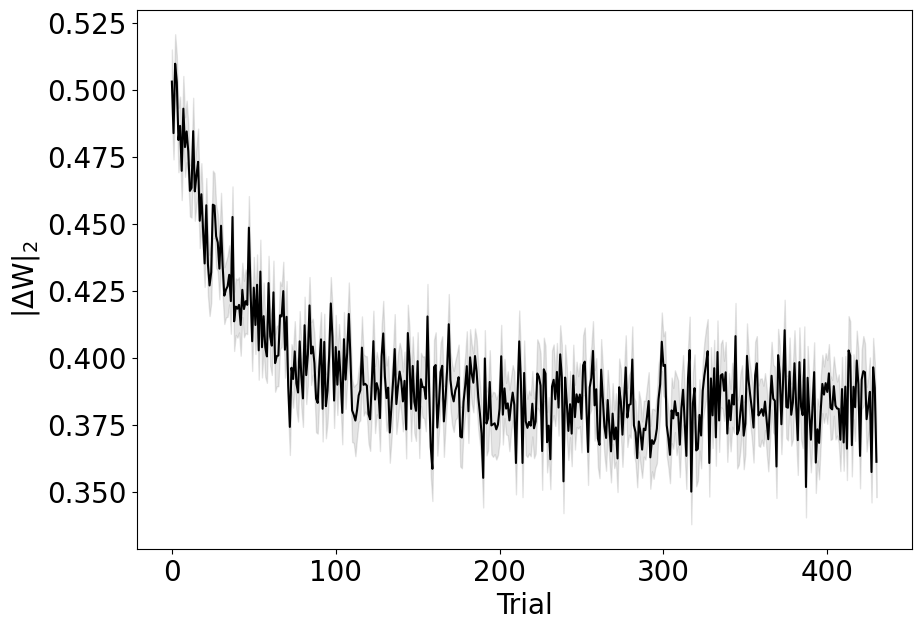

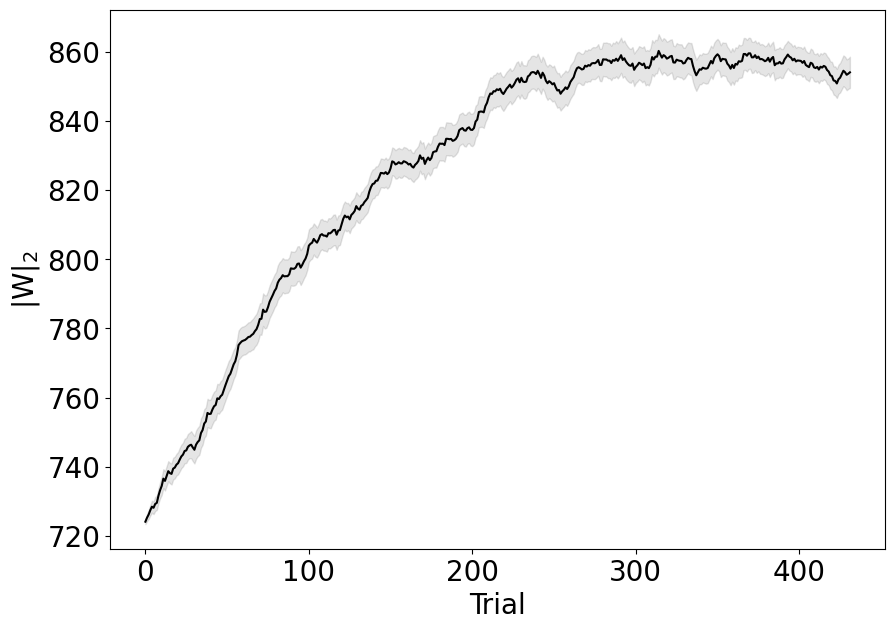

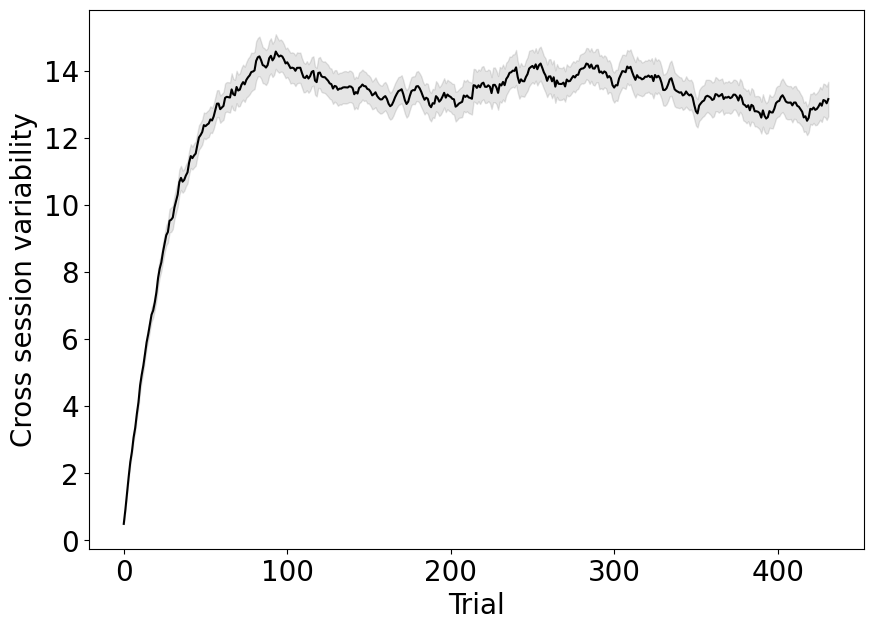

In [39]:
# all_saved_states['whs_final'].shape
plot_weight_summary(args, all_saved_states['whs_final'])

# Plot Initial Connectivity

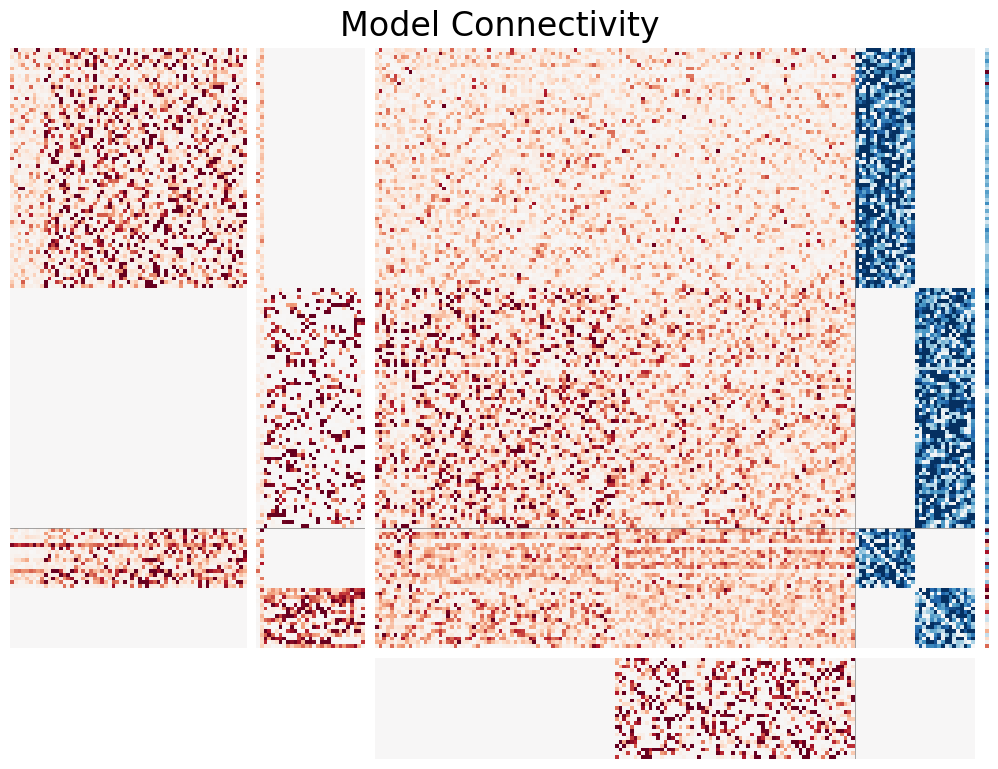

Figure saved at plots/exp/dual_hierarchical_good_based/connectivity.pdf


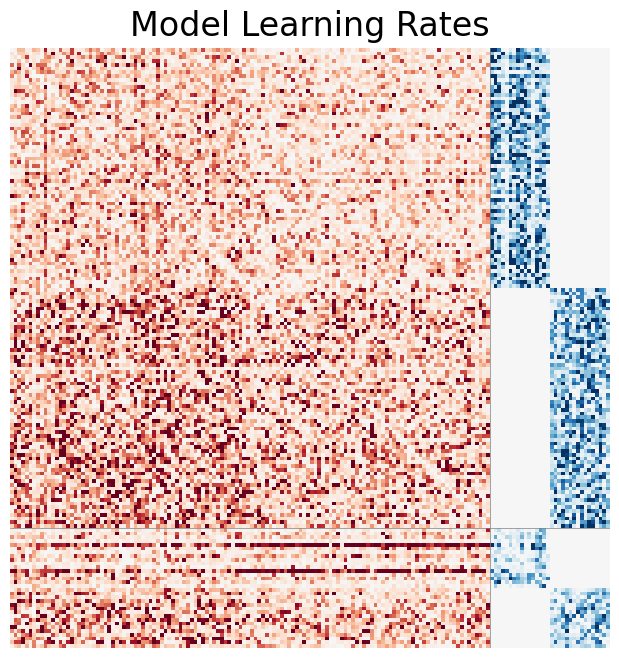

Figure saved at plots/exp/dual_hierarchical_good_based/learning_rates.pdf


In [40]:
plot_connectivity_lr(torch.arange(160), 
                             x2hw=model.rnn.x2h.effective_weight().detach(),
                             h2hw=model.rnn.h2h.effective_weight().detach(),
                             hb=state_dict['rnn.h2h.bias'].detach(),
                             h2ow=torch.cat([torch.zeros(27, 64), model.h2o.effective_weight().detach(), torch.zeros(27, 16*2)], dim=1),
                             aux2h=model.rnn.aux2h.effective_weight().detach(),
                             kappa_rec=model.rnn.kappa_rec.squeeze().abs().detach()*model.rnn.h2h.mask,
                             e_size=int(args['e_prop']*args['hidden_size'])*args['num_areas'], args=args)

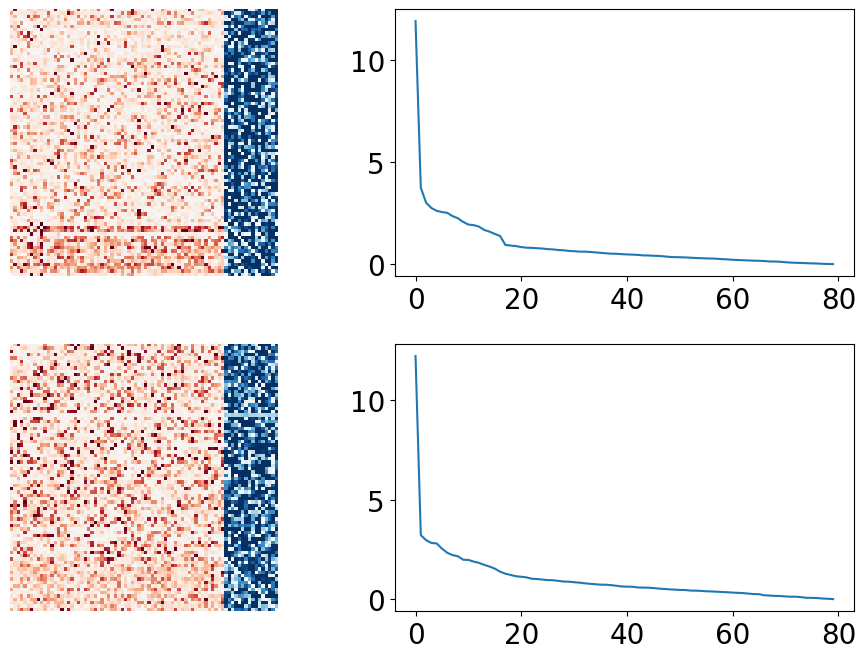

In [41]:
h2h = model.rnn.h2h.effective_weight().detach()

rec_intra = []
us = []
vhs = []
ss = []
for i in range(NUM_AREAS):
    rec_intra.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                      [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
    u, s, vh = np.linalg.svd(rec_intra[i], full_matrices=False)
    us.append(u)
    vhs.append(vh)
    ss.append(s)
    
fig, axes = plt.subplots(NUM_AREAS, 2)
for i in range(NUM_AREAS):
    wlim = np.percentile(rec_intra[i].abs(), 90)
    axes[i,0].imshow(rec_intra[i], vmax=wlim, vmin=-wlim, cmap='RdBu_r', interpolation='nearest')
    axes[i,1].plot(ss[i])
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].axis('off')
#     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
plt.tight_layout()
plt.show()

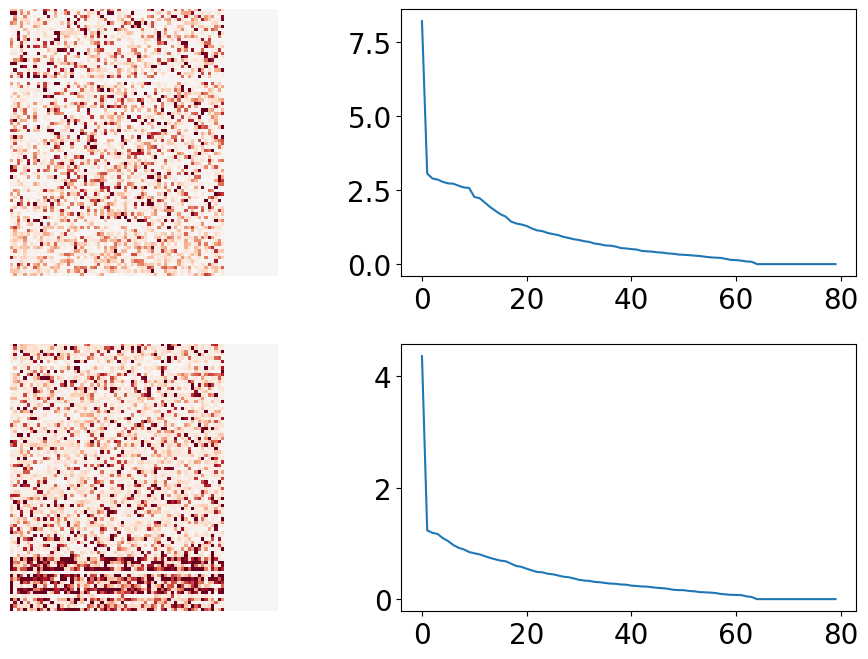

In [42]:
rec_inter_ff = []
rec_inter_fb = []
us_ff = []
us_fb = []
vhs_ff = []
vhs_fb = []
ss_ff = []
ss_fb = []
for i in range(NUM_AREAS-1):
   rec_inter_ff.append(h2h[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                            list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                         [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                            list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
   rec_inter_fb.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                            list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                         [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                            list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
   u, s, vh = np.linalg.svd(rec_inter_ff[i], full_matrices=False)
   us_ff.append(u)
   vhs_ff.append(vh)
   ss_ff.append(s)
   u, s, vh = np.linalg.svd(rec_inter_fb[i], full_matrices=False)
   us_fb.append(u)
   vhs_fb.append(vh)
   ss_fb.append(s)
   
    
fig, axes = plt.subplots(2,2)
wlim = 0.5
for i in range(NUM_AREAS-1):
    axes[0,0].imshow(rec_inter_ff[i], vmin=-wlim, vmax=wlim, cmap='RdBu_r')
    axes[0,0].set_xticks([])
    axes[0,0].set_yticks([])
    axes[0,0].axis('off')
    axes[0,1].plot(ss_ff[i])
#     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
    axes[1,0].imshow(rec_inter_fb[i], vmin=-wlim/3, vmax=wlim/3, cmap='RdBu_r')
    axes[1,0].set_xticks([])
    axes[1,0].set_yticks([])
    axes[1,0].axis('off')
    axes[1,1].plot(ss_fb[i])
#     axes[i,3].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
plt.tight_layout()
plt.show()

SignificanceResult(statistic=0.054083976980047854, pvalue=2.69243970877587e-16)

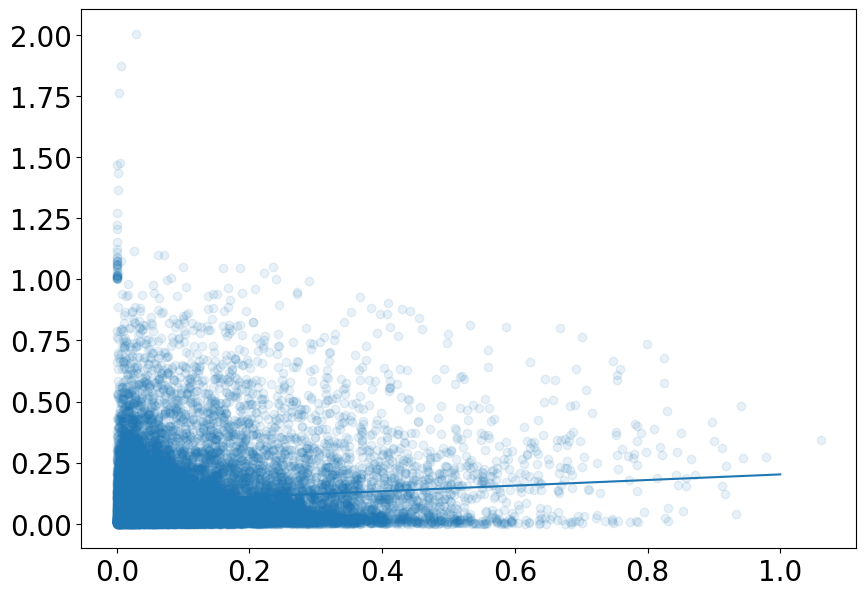

In [43]:
import scipy.stats as stats
plt.scatter(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0], \
            model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0], \
           alpha=0.1)
a, b = np.polyfit(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0], \
                  model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0], 1)
plt.plot(np.linspace(0, 1, 100), a*np.linspace(0, 1, 100)+b)
stats.spearmanr(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0], \
               model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0])

# Subspace Analysis


### Decompose each input pattern as a sum of feature, conjunction, and object patterns
$I_{in,i} = I_{ft}(i)+I_{conj}(i)+I_{obj}(i)$

In [44]:
input_weight_inds = list(range(E_SIZE)) + list(range(E_SIZE*args['num_areas'], E_SIZE*args['num_areas']+I_SIZE))

stims, global_avg_in, ft_avg_in, conj_avg_in, obj_avg_in = get_input_encodings(
    model.rnn.x2h.effective_weight()[input_weight_inds].detach().numpy(), 
    task_mdprl.stim_encoding('all_onehot'))

# global_avg_out, ft_avg_out, conj_avg_out, obj_avg_out = get_input_encodings(
#     model.h2o.effective_weight().detach().numpy().T, np.eye(27))

## Use dPCA to get ft/conj/obj specific axes in the input and output weights

In [45]:
n_components_for_dpca = {'s':2, 'c':2, 'p':2, 'sc':4, 'sp':4, 'cp':4, 'scp': 8}

dpca_in = dPCA.dPCA('scp', n_components=n_components_for_dpca, regularizer=None)
low_stims = dpca_in.fit_transform(stims.reshape((80,3,3,3)))

dpca_out = dPCA.dPCA('scp', n_components=n_components_for_dpca, regularizer=None)
low_output = dpca_out.fit_transform(model.h2o.effective_weight().detach().numpy().T.reshape((E_SIZE,3,3,3)))

dpca_ch = dPCA.dPCA('scp', n_components=n_components_for_dpca, regularizer=None)
low_ch = dpca_ch.fit_transform(model.rnn.aux2h.effective_weight().detach().numpy()[list(range(64, 128))+list(range(144, 160)),2:].reshape((80,3,3,3)))

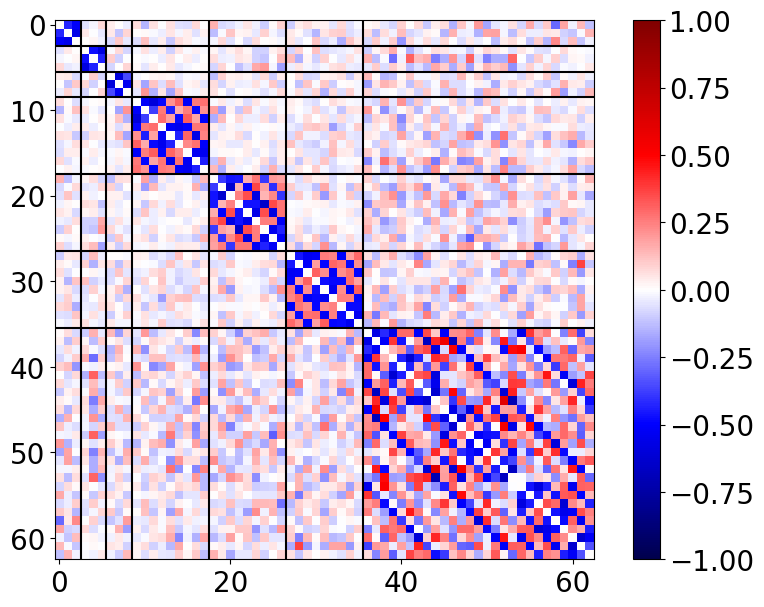

In [46]:
figure = plt.figure()
ft_avg_normed = ft_avg_in/np.sqrt(np.sum(ft_avg_in**2, 1)[:,None])
conj_avg_normed = conj_avg_in/np.sqrt(np.sum(conj_avg_in**2, 1)[:,None])
obj_avg_normed = obj_avg_in/np.sqrt(np.sum(obj_avg_in**2, 1)[:,None])

# plt.imshow(np.concatenate([ft_avg_normed, conj_avg_normed, obj_avg_normed])@np.concatenate([ft_avg_normed, conj_avg_normed, obj_avg_normed]).T-np.eye(63), cmap='seismic', vmin=-1, vmax=1)
plt.imshow(np.corrcoef(np.concatenate([ft_avg_normed, conj_avg_normed, obj_avg_normed]))-np.eye(63), cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()

block_boundaries = [2.5, 5.5, 8.5, 17.5, 26.5, 35.5]
for i in block_boundaries:
    plt.axvline(x=i,color='black')
    plt.axhline(y=i,color='black')
    
plt.show()



Figure saved at plots/exp/dual_hierarchical_good_based/input_output_weight_variance.pdf


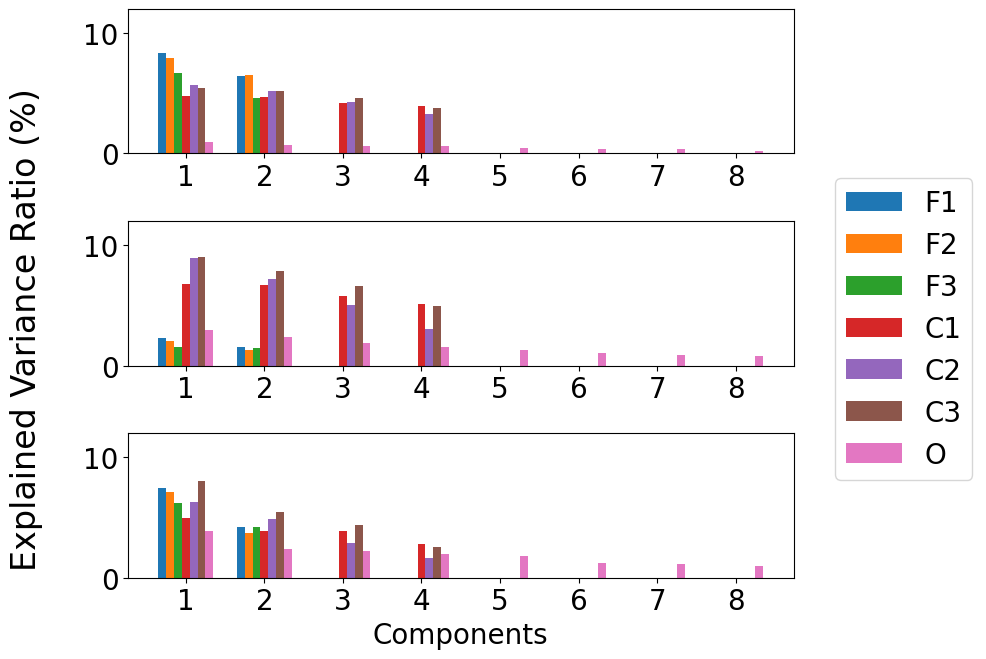

In [47]:
fig, axes = plt.subplots(3,1)

bar_width = 0.1
labels = ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O']

key_plot_order = ['s', 'c', 'p', 'cp', 'sp', 'sc', 'scp']

for k_idx, k in enumerate(key_plot_order):
    bar_x = np.arange(len(dpca_in.explained_variance_ratio_[k]))
    axes[0].bar(bar_x+bar_width*(k_idx-len(low_stims.keys())//2), np.array(dpca_in.explained_variance_ratio_[k])*100, width=bar_width, label=labels[k_idx])
    axes[1].bar(bar_x+bar_width*(k_idx-len(low_stims.keys())//2), np.array(dpca_out.explained_variance_ratio_[k])*100, width=bar_width, label=labels[k_idx])
    axes[2].bar(bar_x+bar_width*(k_idx-len(low_stims.keys())//2), np.array(dpca_ch.explained_variance_ratio_[k])*100, width=bar_width, label=labels[k_idx])

axes[2].set_xlabel('Components')
axes[0].set_xticks(np.arange(0,8,1))
axes[1].set_xticks(np.arange(0,8,1))
axes[2].set_xticks(np.arange(0,8,1))
axes[0].set_xticklabels(np.arange(1,9,1))
axes[1].set_xticklabels(np.arange(1,9,1))
axes[2].set_xticklabels(np.arange(1,9,1))
axes[0].set_ylim([-0.0, 12])
axes[1].set_ylim([-0.0, 12])
axes[2].set_ylim([-0.0, 12])
fig.supylabel('Explained Variance Ratio (%)')
plt.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
box = axes[1].get_position()
axes[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
box = axes[2].get_position()
axes[2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
fig.legend(handles, labels, loc='center right')

with PdfPages(f'plots/{args["exp_dir"]}/input_output_weight_variance.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/input_output_weight_variance.pdf')


Figure saved at plots/exp/dual_hierarchical_good_based/input_axis_overlap.pdf


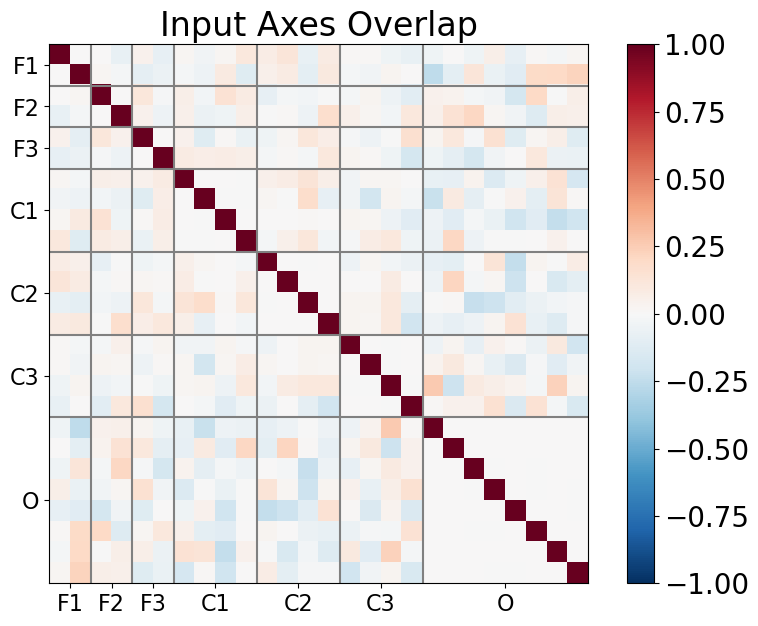

In [48]:
all_dpca_axes = np.concatenate([dpca_in.P['s'], dpca_in.P['c'], dpca_in.P['p'], 
                                dpca_in.P['cp'], dpca_in.P['sp'], dpca_in.P['sc'], 
                                dpca_in.P['scp']], axis=1)
axes_overlap = all_dpca_axes.T@all_dpca_axes
# sig_thresh = np.abs(norm.ppf(0.05/(26*25/2-3-7*3-28))/np.sqrt(100))
sig_thresh = np.abs(norm.ppf(0.001)/np.sqrt(args['hidden_size']))
axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0)



plt.imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Input Axes Overlap')
plt.xlabel('')

txs, tys = np.meshgrid(np.arange(sum(n_components_for_dpca.values())),np.arange(sum(n_components_for_dpca.values())))
txs = txs[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]
tys = tys[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]

block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]-0.5
for i in block_boundaries:
    plt.axvline(x=i,color='grey')
    plt.axhline(y=i,color='grey')
    
tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+np.array(list(n_components_for_dpca.values()))//2-0.5

plt.xticks(tick_locs, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
plt.yticks(tick_locs, ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

for (x,y) in zip(txs, tys):
    if x<=y:
        continue
    else:
        plt.text(x-0.25, y+0.55, '*', {'size': 16})
        
with PdfPages(f'plots/{args["exp_dir"]}/input_axis_overlap.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/input_axis_overlap.pdf')

Figure saved at plots/exp/dual_hierarchical_good_based/output_axis_overlap.pdf


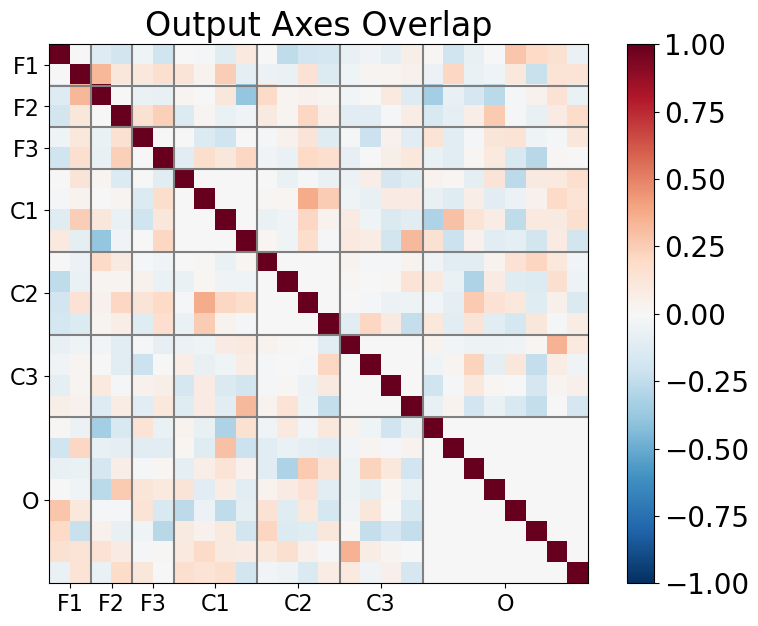

In [49]:
all_dpca_axes = np.concatenate([dpca_out.P['s'], dpca_out.P['c'], dpca_out.P['p'], 
                                dpca_out.P['cp'], dpca_out.P['sp'], dpca_out.P['sc'], 
                                dpca_out.P['scp']], axis=1)
axes_overlap = all_dpca_axes.T@all_dpca_axes
# sig_thresh = np.abs(norm.ppf(0.05/(26*25/2-3-7*3-28))/np.sqrt(100))
sig_thresh = np.abs(norm.ppf(0.001)/np.sqrt(args['hidden_size']))

axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0)

plt.imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Output Axes Overlap')
plt.xlabel('')

txs, tys = np.meshgrid(np.arange(6+12+8),np.arange(6+12+8))
txs = txs[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]
tys = tys[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]

block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]-0.5
for i in block_boundaries:
    plt.axvline(x=i,color='grey')
    plt.axhline(y=i,color='grey')
    
plt.xticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
plt.yticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

for (x,y) in zip(txs, tys):
    if x<=y:
        continue
    else:
        plt.text(x-0.25, y+0.55, '*', {'size': 16})
        
with PdfPages(f'plots/{args["exp_dir"]}/output_axis_overlap.pdf') as pdf:
    pdf.savefig()
    print(f'Figure saved at plots/{args["exp_dir"]}/output_axis_overlap.pdf')
        

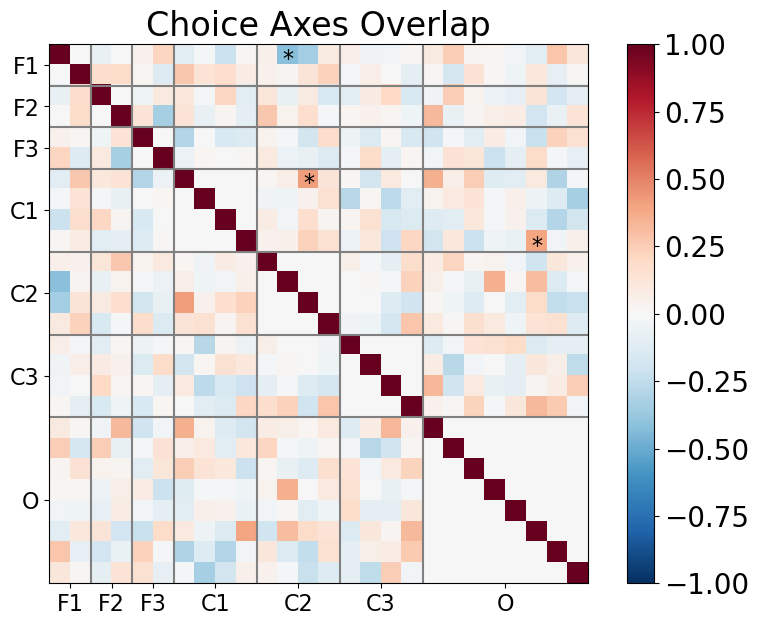

In [50]:
all_dpca_axes = np.concatenate([dpca_ch.P['s'], dpca_ch.P['c'], dpca_ch.P['p'], 
                                dpca_ch.P['cp'], dpca_ch.P['sp'], dpca_ch.P['sc'], 
                                dpca_ch.P['scp']], axis=1)
axes_overlap = all_dpca_axes.T@all_dpca_axes
sig_thresh = np.abs(norm.ppf(0.001)/np.sqrt(args['hidden_size']))

axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0)

plt.imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Choice Axes Overlap')
plt.xlabel('')

txs, tys = np.meshgrid(np.arange(6+12+8),np.arange(6+12+8))
txs = txs[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]
tys = tys[(np.abs(axes_overlap)>sig_thresh) & (axes_corr_ps<0.001)]

block_boundaries = [1.5, 3.5, 5.5, 9.5, 13.5, 17.5]
for i in block_boundaries:
    plt.axvline(x=i,color='grey')
    plt.axhline(y=i,color='grey')
    
plt.xticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)
plt.yticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=16)

for (x,y) in zip(txs, tys):
    if x<=y:
        continue
    else:
        plt.text(x-0.25, y+0.55, '*', {'size': 16})
        
# with PdfPages(f'plots/{args["exp_dir"]}/output_axis_overlap.pdf') as pdf:
#     pdf.savefig()
#     print(f'Figure saved at plots/{args["exp_dir"]}/output_axis_overlap.pdf')
        

The input and output weights are both low-rank, and their encoding subspaces have very little overlap.

# Activity of the Naive RNN

In [114]:
# shape [num pairs (216=27X8), samples per pair, time steps, batch size=1, num_hidden]

pair_to_ind = {(0,1): 0, (1,0): 1, (0,2): 2, (2,0): 3, (1,2): 4, (2,1): 5};

num_pairs, samples_per_pair, num_timesteps, _, num_hidden = all_initial_saved_states['hs'].shape

mat_for_dpca = np.empty((samples_per_pair, 6, 6, 6, num_timesteps, num_hidden))

for pair_idx in range(task_mdprl.pairs.shape[0]):
    opt1_idx = task_mdprl.pairs[pair_idx,:][0]
    opt2_idx = task_mdprl.pairs[pair_idx,:][1]
    shp_idx = pair_to_ind[(task_mdprl.index_shp[opt1_idx], task_mdprl.index_shp[opt2_idx])]
    clr_idx = pair_to_ind[(task_mdprl.index_clr[opt1_idx], task_mdprl.index_clr[opt2_idx])]
    pttrn_idx = pair_to_ind[(task_mdprl.index_pttrn[opt1_idx], task_mdprl.index_pttrn[opt2_idx])]
    mat_for_dpca[:, shp_idx, clr_idx, pttrn_idx, :, :] = all_initial_saved_states['hs'][pair_idx,:,:,0,:].mean(0)
    
mat_for_dpca = mat_for_dpca.mean(0).transpose((4, 3, 0, 1, 2))

In [115]:
mat_for_dpca.shape

(160, 58, 6, 6, 6)

In [116]:
dpca_rec_area = []
low_stims = []

for i in range(NUM_AREAS):
    area_spec_units = list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                         list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))

    dpca_rec_area.append(dPCA.dPCA('tscp', n_components={'t':5, 'ts':8, 'tc':8, 'tp':8, 'tsc': 8, 'tsp':8, 'tcp':8, 'tscp':8},
                    join={'ts' : ['s','ts'], 'tc' : ['c','tc'], 'tp' : ['p','tp'], 
                          'tsp' : ['sp','tsp'], 'tsc' : ['sc','tsc'], 'tcp' : ['cp','tcp'],
                          'tscp' : ['scp','tscp'],}, regularizer=None))
    low_stims.append(dpca_rec_area[i].fit_transform(mat_for_dpca[area_spec_units,:43,...]))


(0, 'ts', 0.02756223696767063)
(0, 'tc', 0.023529631236225996)
(0, 'tp', 0.02620472337961283)
(0, 'tsp', 0.2000117313660808)
(0, 'tsc', 0.15484863033977742)
(0, 'tcp', 0.15450066260210843)
(0, 'tscp', 0.05985260825716069)
(1, 'ts', 0.009339157729804556)
(1, 'tc', 0.009566340673766457)
(1, 'tp', 0.009134171054818173)
(1, 'tsp', 0.1856630989397768)
(1, 'tsc', 0.16512432376371944)
(1, 'tcp', 0.152815834122824)
(1, 'tscp', 0.04884188243830505)


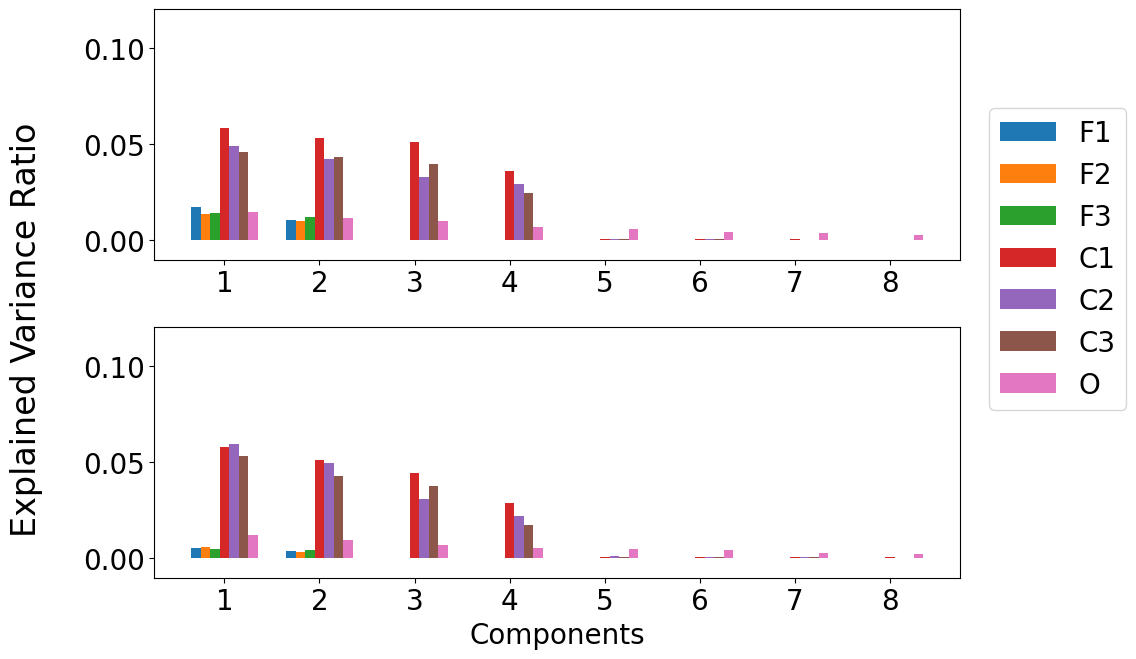

In [117]:
fig, axes = plt.subplots(NUM_AREAS,1)

bar_width = 0.1
labels = ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O']

for i in range(NUM_AREAS):
    for k_idx, k in enumerate(low_stims[i].keys()):
        if k!='t':
#             axes[i].plot(dpca_rec_area[i].explained_variance_ratio_[k][:10], '-o', label=k)
            bar_x = np.arange(len(dpca_rec_area[i].explained_variance_ratio_[k]))
            axes[i].bar(bar_x+bar_width*(k_idx-len(low_stims[i].keys())//2), dpca_rec_area[i].explained_variance_ratio_[k], width=bar_width, label=labels[k_idx-1])
            axes[i].set_xticks(np.arange(0,8))
            axes[i].set_xticklabels(np.arange(1,9))
            axes[i].set_ylim([-0.01, 0.12])
            print((i, k, sum(dpca_rec_area[i].explained_variance_ratio_[k])))
#             handles, labels = axes[i].get_legend_handles_labels()
#             box = axes[i].get_position()
#             axes[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])

axes[-1].set_xlabel('Components')
fig.supylabel('Explained Variance Ratio')
plt.tight_layout()

fig.legend(handles, labels, bbox_to_anchor = (1.15, 0.6), loc='center right')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 26 but corresponding boolean dimension is 56

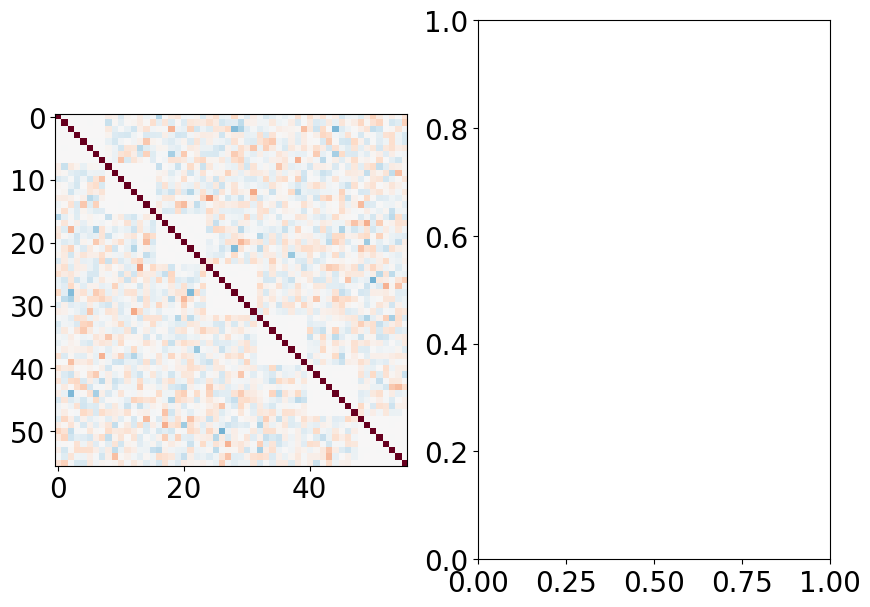

In [61]:
fig, axes = plt.subplots(1,NUM_AREAS)


for i in range(NUM_AREAS):

    all_dpca_axes = np.concatenate([dpca_rec_area[i].P['ts'], dpca_rec_area[i].P['tc'], dpca_rec_area[i].P['tp'], 
                                    dpca_rec_area[i].P['tcp'], dpca_rec_area[i].P['tsp'], dpca_rec_area[i].P['tsc'], 
                                    dpca_rec_area[i].P['tscp']], axis=1)
    axes_overlap = all_dpca_axes.T@all_dpca_axes
    sig_thresh = np.abs(norm.ppf(0.05/(26*25/2-3-7*3-28))/np.sqrt(100))

    axes[i].imshow(axes_overlap, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[i].set_xlabel('')

    txs, tys = np.meshgrid(np.arange(6+12+8),np.arange(6+12+8))
    txs = txs[np.abs(axes_overlap)>sig_thresh]
    tys = tys[np.abs(axes_overlap)>sig_thresh]

    block_boundaries = [1.5, 3.5, 5.5, 9.5, 13.5, 17.5]
    for j in block_boundaries:
        axes[i].axvline(x=j,color='grey')
        axes[i].axhline(y=j,color='grey')

    axes[i].set_xticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=12)
    axes[i].set_yticks([0.5,2.5,4.5,7.5,11.5,15.5,21.5], ['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'], size=12)

    for (x,y) in zip(txs, tys):
        if x<=y:
            continue
        else:
            axes[i].text(x-0.5, y+0.75, '*', {'size': 12})
            
    axes[i].set_title(f'Area{i+1}', size=16)

fig.suptitle('Area Encoding Axes Overlap', y=0.75)
plt.tight_layout()
fig.show()

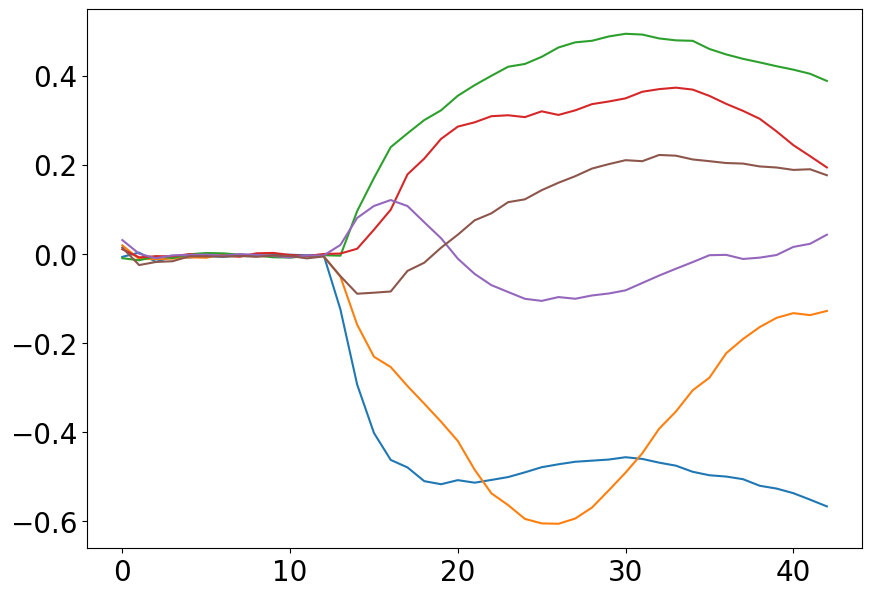

In [111]:
plt.plot(low_stims[0]['tp'][1,:,0,0,:].reshape((43, 6)))

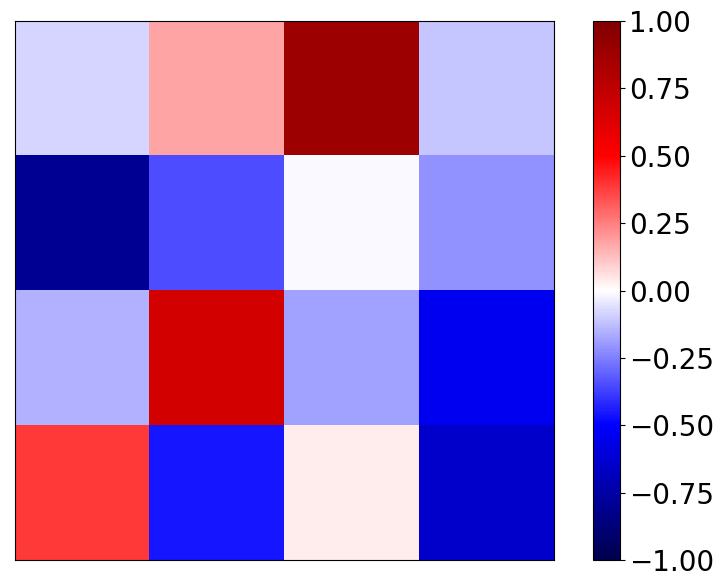

In [170]:
plt.imshow(dpca_ch.P['sc'].T@dpca_in.P['sc'], vmin=-1, vmax=1, cmap='seismic')
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [226]:
cca = CCA(n_components=4).fit(dpca_ch.P['sc'], dpca_in.P['cp'])
# ch_s, in_s = cca.transform(dpca_ch.P['c'], dpca_in.P['c'])
cca.score(dpca_ch.P['sc'], dpca_in.P['cp'])

-0.7270408349027491

In [218]:
 dpca_in.explained_variance_ratio_

{'s': [0.0679702876653987, 0.05145532467590208],
 'c': [0.07004655371594026, 0.051306010707226846],
 'p': [0.05685449315937463, 0.05083538653203956],
 'sc': [0.06224519218311009,
  0.05674850926857522,
  0.04975797929343129,
  0.039492424808457494],
 'sp': [0.06482585959985221,
  0.06299627617102055,
  0.05505429765091763,
  0.04732805754114644],
 'cp': [0.05894831841947212,
  0.05099889486910525,
  0.035191733718272666,
  0.033532960612481344],
 'scp': [0.007255854642412407,
  0.005726030378427782,
  0.005041004530995319,
  0.0040824433761889045,
  0.0037585933098491786,
  0.0033921938713648014,
  0.002822131969560382,
  0.002333187329476516]}

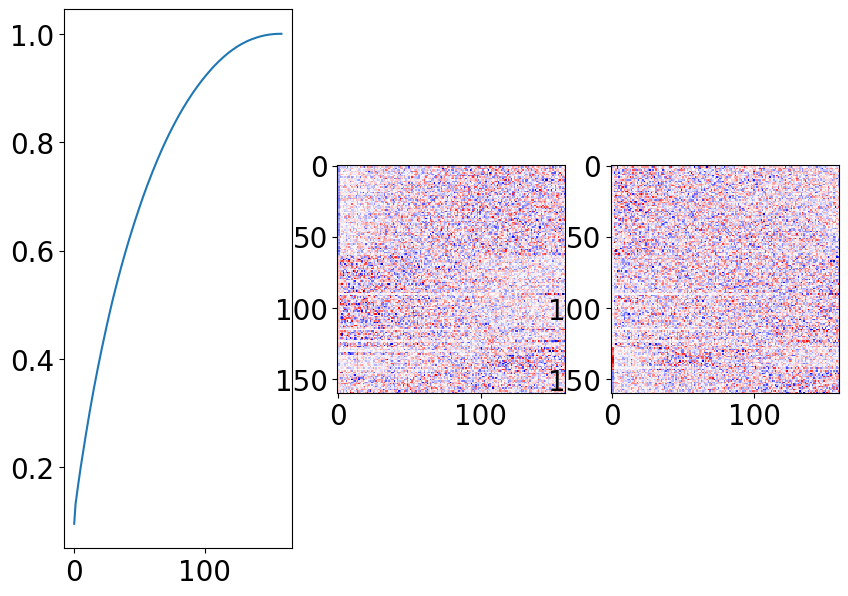

In [55]:
lr_mat = (model.rnn.kappa_rec.squeeze().abs().detach()*model.rnn.h2h.mask)
[u, s, vh] = np.linalg.svd(lr_mat)
plt.subplot(131).plot(np.cumsum(s[:])/np.sum(s))
plt.subplot(132).imshow(u[:,:], cmap='seismic', vmin=-0.5, vmax=0.5)
plt.subplot(133).imshow(vh[:,:].T, cmap='seismic', vmin=-0.5, vmax=0.5)

In [51]:
def get_dpca(Xs, labels, n_components):
    all_non_time_labels = labels
    join_dict = {}
    for r in range(1, len(labels)+1):
        for label in list(itertools.combinations(all_non_time_labels, r)):
            label_str = ''.join(label)
            join_dict['t'+label_str] = [label_str, 't'+label_str]

    dpca_model = dPCA.dPCA('t'+labels, join=join_dict, n_components=n_components)
    low_hs = dpca_model.fit_transform(Xs)

    all_axes = []
    all_explained_vars = []
    all_labels = []
    for k in dpca_model.marginalized_psth.keys():
        if k=='t':
            continue
        eff_components = np.sum(np.array(dpca_model.explained_variance_ratio_[k])>0.00)
        all_explained_vars.append(dpca_model.explained_variance_ratio_[k][:eff_components])
        print(f"Variance explained by {eff_components} of {k}: {round(100*sum(dpca_model.explained_variance_ratio_[k]),2)} %")
        all_axes.append(dpca_model.P[k][:,:eff_components])
        all_labels += [k]*eff_components

    all_axes = np.concatenate(all_axes, axis=1)
    all_explained_vars = np.concatenate(all_explained_vars, axis=0)

    return low_hs, dpca_model.P, all_explained_vars, all_labels, dpca_model.marginalized_psth

def plot_dpca(all_saved_states, task_mdprl, args, num_trials_to_fit=432, area_to_fit=1):
    '''
    (1) regress hs activity with
            previous trial choice shape, color, pattern (3x3x3), 
            previous trial reward (2),
            current trial stimuli shape, color, pattern pairs (3x3x3), 
            current trial choice shape, color, pattern (3x3x3), 
            current trial reward (2),
    (2) get beta weights which is a mixture of value and stimulus intensity: h ~ Xw. 
        This will give beta weights timepoints X trials X hidden X latent variables,
        calculate cpd gives timepoints X trials X hidden X latent variables CPD values
    (3) compare w with marginal reward probability? see which it dimension it corresponds to the best
    '''
    
    n_trials, n_timesteps, n_sessions, n_hidden = all_saved_states['hs'].shape
    n_areas = args['num_areas'] 

    print("Calculating PSTH by prev trial")

    '''
    organize by previous trial outcome
    '''
    hs_by_prev = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes

    flat_hs_post = all_saved_states['hs'].numpy()[1:num_trials_to_fit,...].transpose((2,0,1,3)).reshape((n_sessions*(num_trials_to_fit-1), n_timesteps, n_hidden))
    flat_rwds_pre = all_saved_states['rewards'].numpy()[:num_trials_to_fit-1,...].transpose((2,0,1)).reshape((n_sessions*(num_trials_to_fit-1)))
    flat_acts_pre = all_saved_states['choices'].numpy()[:num_trials_to_fit-1,...].transpose((2,0,1)).reshape((n_sessions*(num_trials_to_fit-1)))

    # the prev_f{}_vals are IN TERMS OF THE REWARD SCHEDULE, NOT THE PERCEPTUAL DIMENSIONS

    act_f1_val = task_mdprl.index_shp[flat_acts_pre]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_pre]
    act_f3_val = task_mdprl.index_clr[flat_acts_pre]
    
    for prev_rwd_val in range(2):
        for prev_f1_val in range(3): 
            for prev_f2_val in range(3):
                for prev_f3_val in range(3):
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_pre==prev_rwd_val) & \
                                  (act_f1_val==prev_f1_val) & \
                                  (act_f2_val==prev_f2_val) & \
                                  (act_f3_val==prev_f3_val)
                    hs_by_prev[:, :, prev_rwd_val, prev_f1_val, prev_f2_val, prev_f3_val] = flat_hs_post[where_trial,...].mean(0).T

    del flat_hs_post
    del flat_rwds_pre
    del flat_acts_pre
    
    '''
    organize by current trial stimuli
    '''
    print("Calculating PSTH by current trial stimuli")
    hs_by_curr_stim = np.zeros((n_hidden, n_timesteps, 6, 6, 6)) # sort data by current trial choices and outcomes

    flat_hs_curr = all_saved_states['hs'][:num_trials_to_fit].numpy().transpose((2,0,1,3)).reshape((n_sessions*num_trials_to_fit, n_timesteps, n_hidden))
    flat_stims = all_saved_states['stimuli'][:num_trials_to_fit].numpy().transpose((2,0,1,3)).reshape((n_sessions*num_trials_to_fit, 2))

    pair_to_ind = {(0,1): 0, (1,0): 1, (0,2): 2, (2,0): 3, (1,2): 4, (2,1): 5}

    stim_f1_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f2_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f3_val = np.ones_like(flat_stims[:,0])*np.nan
    
    for k, v in pair_to_ind.items():
        stim_f1_val[(task_mdprl.index_shp[flat_stims[:,0]]==k[0]) & (task_mdprl.index_shp[flat_stims[:,1]]==k[1])] = v
        stim_f2_val[(task_mdprl.index_pttrn[flat_stims[:,0]]==k[0]) & (task_mdprl.index_pttrn[flat_stims[:,1]]==k[1])] = v
        stim_f3_val[(task_mdprl.index_clr[flat_stims[:,0]]==k[0]) & (task_mdprl.index_clr[flat_stims[:,1]]==k[1])] = v
    
    
    for curr_f1_val in range(6):
        for curr_f2_val in range(6):
            for curr_f3_val in range(6):
                # n_trials, 1, n_sessions, ...

#                 print(task_mdprl.index_shp[flat_stims[:,0]], task_mdprl.index_pttrn[flat_stims[:,0]], task_mdprl.index_clr[flat_stims[:,0]])
#                 print(task_mdprl.index_shp[flat_stims[:,1]], task_mdprl.index_pttrn[flat_stims[:,1]], task_mdprl.index_clr[flat_stims[:,1]])
#                 print(stim_f1_val, stim_f2_val, stim_f3_val)
                where_trial = (stim_f1_val==curr_f1_val) & \
                              (stim_f2_val==curr_f2_val) & \
                              (stim_f3_val==curr_f3_val)
                hs_by_curr_stim[:, :, curr_f1_val, curr_f2_val, curr_f3_val] = flat_hs_curr[where_trial,...].mean(0).T

    del flat_stims

    '''
    organize by current trial outcome
    '''
    print("Calculating PSTH by current trial outcome")
    hs_by_curr_outcome = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    flat_rwds_curr = all_saved_states['rewards'][:num_trials_to_fit,...].numpy().transpose((2,0,1)).reshape((n_sessions*num_trials_to_fit))
    flat_acts_curr = all_saved_states['choices'][:num_trials_to_fit,...].numpy().transpose((2,0,1)).reshape((n_sessions*num_trials_to_fit))

    for curr_rew_val in range(2):
        for curr_f1_val in range(3):
            for curr_f2_val in range(3):
                for curr_f3_val in range(3):
                    # n_trials, 1, n_sessions, ...
                    act_f1_val = task_mdprl.index_shp[flat_acts_curr]
                    act_f2_val = task_mdprl.index_pttrn[flat_acts_curr]
                    act_f3_val = task_mdprl.index_clr[flat_acts_curr]
                    where_trial = (flat_rwds_curr==curr_rew_val) & \
                                  (act_f1_val==curr_f1_val) & \
                                  (act_f2_val==curr_f2_val) & \
                                  (act_f3_val==curr_f3_val)
                    hs_by_curr_outcome[:, :, curr_rew_val, curr_f1_val, curr_f2_val, curr_f3_val] = flat_hs_curr[where_trial,...].mean(0).T
         
    del flat_hs_curr
    del flat_rwds_curr
    del flat_acts_curr


    print("-------------------------------------------")
    print('Calculating DPCA by previous trial outcome')
    low_hs_by_prev, all_axes_by_prev, all_explained_vars_by_prev, all_labels_by_prev, all_psth_by_prev = \
        get_dpca(hs_by_prev, "rscp", n_components=20)
    print("-------------------------------------------")
    print('Calculating DPCA by current trial stimuli')
    low_hs_by_curr_stim, all_axes_by_curr_stim, all_explained_vars_by_curr_stim, all_labels_by_curr_stim, all_psth_by_curr_stim = \
        get_dpca(hs_by_curr_stim, "scp", n_components=20)
    print("-------------------------------------------")
    print('Calculating DPCA by current trial outcome')
    low_hs_by_curr_outcome, all_axes_by_curr_outcome, all_explained_vars_by_curr_outcome, all_labels_by_curr_outcome, all_psth_by_curr_outcome = \
        get_dpca(hs_by_curr_outcome, "rscp", n_components=20)

#     fig, axes = plt.subplots(2, 2)
#     for i in range(4):
#         plot_mean_and_std(axes[i//2, i%2], all_cpds[i].mean([0, 2]), 
#                           all_cpds[i].std([0, 2])/np.sqrt(n_trials//4*n_batch), label=['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'])
    return low_hs_by_prev, low_hs_by_curr_stim, low_hs_by_curr_outcome, \
           all_axes_by_prev, all_axes_by_curr_stim, all_axes_by_curr_outcome, \
           all_psth_by_prev, all_psth_by_curr_stim, all_psth_by_curr_outcome

In [52]:
low_hs_by_prev, low_hs_by_curr_stim, low_hs_by_curr_outcome, \
all_axes_by_prev, all_axes_by_curr_stim, all_axes_by_curr_outcome, \
all_psth_by_prev, all_psth_by_curr_stim, all_psth_by_curr_outcome \
= plot_dpca(all_saved_states, task_mdprl, args)

Calculating PSTH by prev trial
Calculating PSTH by current trial stimuli
Calculating PSTH by current trial outcome
-------------------------------------------
Calculating DPCA by previous trial outcome
Variance explained by 20 of tr: 0.17 %
Variance explained by 20 of ts: 1.13 %
Variance explained by 20 of tc: 1.12 %
Variance explained by 20 of tp: 1.03 %
Variance explained by 20 of trs: 0.08 %
Variance explained by 20 of trc: 0.07 %
Variance explained by 20 of trp: 0.07 %
Variance explained by 20 of tsc: 3.07 %
Variance explained by 20 of tsp: 2.56 %
Variance explained by 20 of tcp: 2.16 %
Variance explained by 20 of trsc: 0.12 %
Variance explained by 20 of trsp: 0.15 %
Variance explained by 20 of trcp: 0.15 %
Variance explained by 20 of tscp: 1.74 %
Variance explained by 20 of trscp: 0.24 %
-------------------------------------------
Calculating DPCA by current trial stimuli
Variance explained by 20 of ts: 2.58 %
Variance explained by 20 of tc: 2.66 %
Variance explained by 20 of tp: 

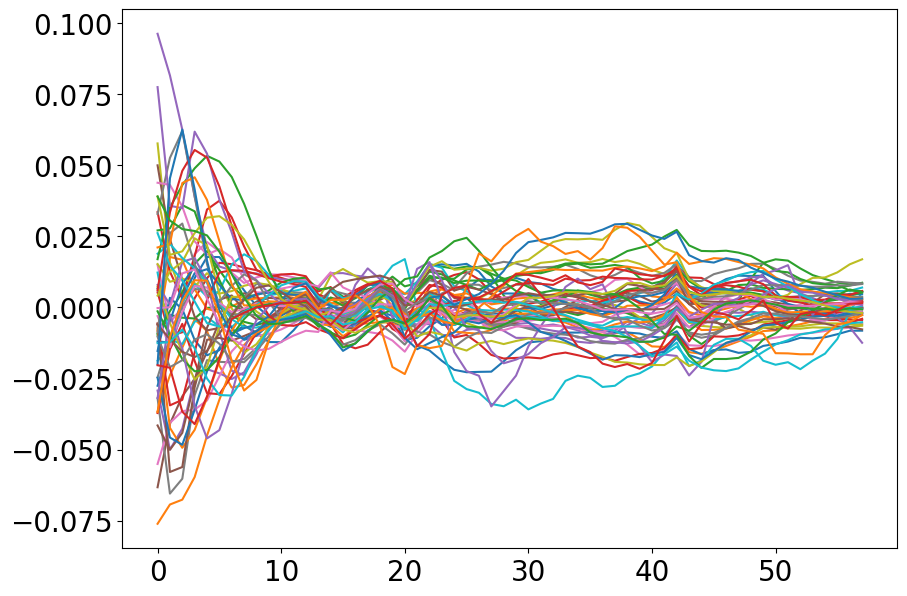

In [67]:
plt.plot(low_hs_by_prev['trcp'][:,:,:,:,:,:].reshape((20, 58, -1))[2]);

In [78]:
# plt.imshow(all_axes_by_curr_stim['ts'].T@all_axes_by_prev['trs'], cmap='seismic', vmin=-0.7, vmax=0.7, interpolation="nearest")
plt.imshow(stats.pearsonr(all_axes_by_curr_outcome['trs'], all_axes_by_prev['trs']).statistic[20:,:20], \
           cmap='seismic', vmin=-1, vmax=1, interpolation="nearest")
plt.colorbar()

ValueError: shapes (160,20) and (160,20) not aligned: 20 (dim 1) != 160 (dim 0)

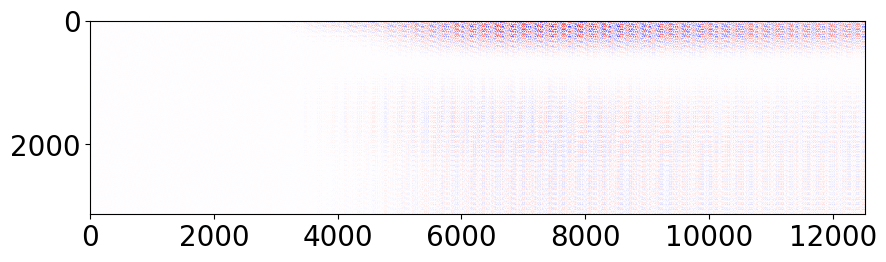

In [121]:
plt.imshow((all_psth_by_curr_stim['tsc'].T@all_psth_by_prev['trsc']).T, vmin=-1, vmax=1, cmap='seismic')

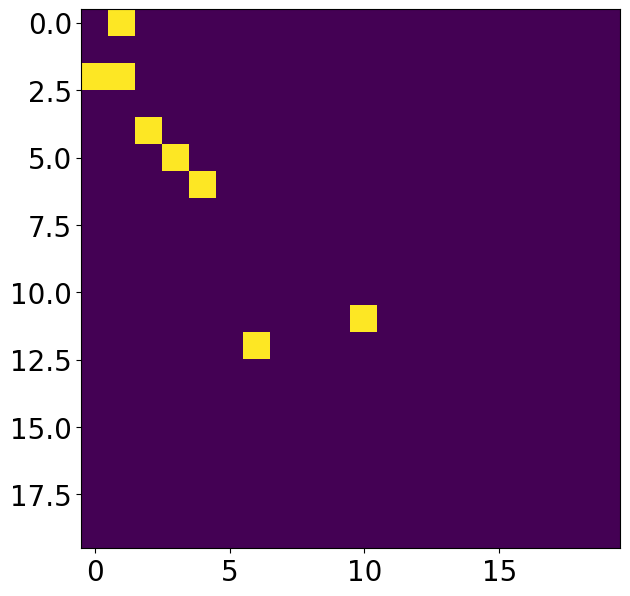

In [123]:
plt.imshow(stats.spearmanr(all_axes_by_curr_stim['ts'], all_axes_by_prev['trs']).pvalue[20:,:20]<0.001)